In [1]:
import time
import cv2
import numpy as np

import utils.image as im_utils
from utils.ai import face_seg
import utils.mask as mask_utils

In [2]:
import importlib
importlib.reload(im_utils)
importlib.reload(mask_utils)

<module 'utils.mask' from 'C:\\GitHub\\portrait-by-number\\flask\\utils\\mask.py'>

In [3]:
jpg = "static/portraits/_example.jpg"

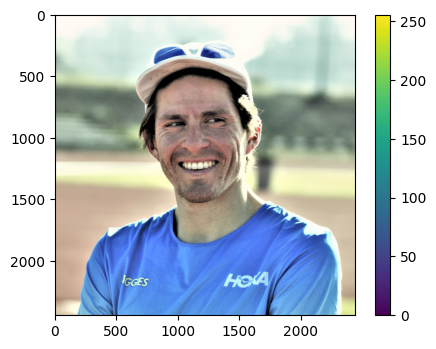

In [4]:
# view example

im = im_utils.load_image(jpg)
im_nat = im_utils.natural_color(im)

im_utils.display_image(im_nat)

image segmentation unique classes:
[ 0  1  2  3  5  7 10 11 12 13 14 16 17 18]


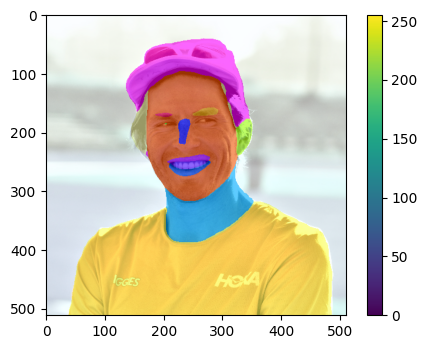

In [5]:
# classify pixels using deep learning model

seg_mask_vis, seg_mask = face_seg.evaluate(im_nat)

print(f'image segmentation unique classes:\n{np.unique(seg_mask)}')
im_utils.display_image(seg_mask_vis)

image segmentation unique classes:
[ 0  1  2  6 10 11 12 13 14 16 18]


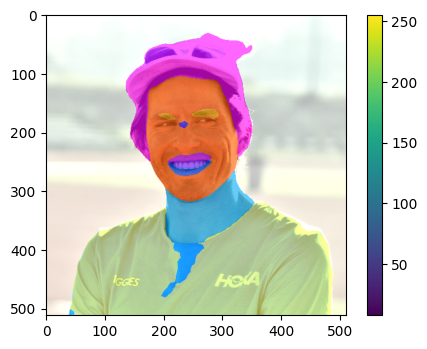

In [28]:
# does face segmentation perform differently when image is enhanced?
# looks like shit wow!

seg_mask_vis_1, seg_mask_1 = face_seg.evaluate(im_enhanced)

print(f'image segmentation unique classes:\n{np.unique(seg_mask_1)}')
im_utils.display_image(seg_mask_vis_1)

In [6]:
# masks
start = time.time()
M = mask_utils.Masks(im_nat)
print(time.time() - start)

2.1523725986480713


(2444, 2444)
uint8


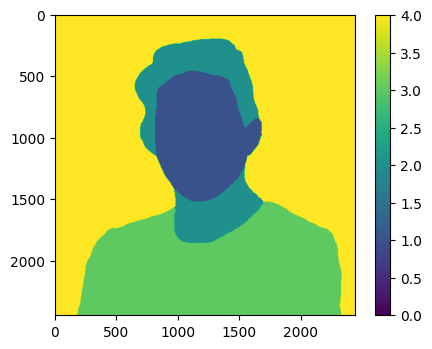

In [7]:
print(M.seg_mask.shape)
print(M.seg_mask.dtype)
im_utils.display_image(M.seg_mask)


Class 1
(2444, 2444)
float32


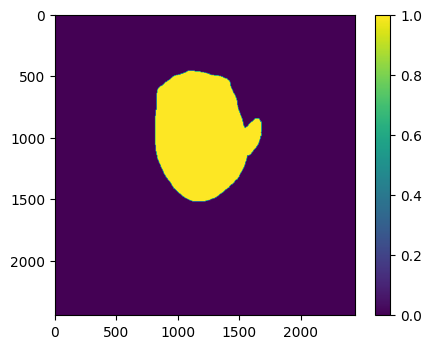


Class 2
(2444, 2444)
float32


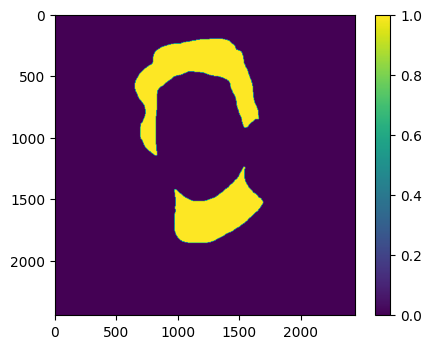


Class 3
(2444, 2444)
float32


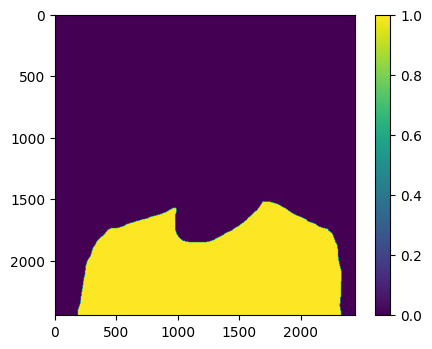


Class 4
(2444, 2444)
float32


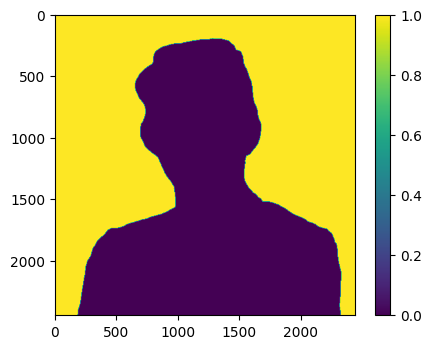

In [8]:
for ix, m in enumerate(M.binary_masks):
    print(f"\nClass {ix + 1}")
    print(m.shape)
    print(m.dtype)
    im_utils.display_image(m)

In [9]:
# Example usage
start = time.time()

segmented_image, centers = im_utils.kmeans_cielab(
    im_utils.blur(im, 12),
    k=20
)
print(f"{round(time.time()-start, 1)}s elapsed")

0.8s elapsed


In [10]:
# saturate colors
im_enhanced = im_utils.increase_vibrance(im, alpha=1.25)

In [11]:
start = time.time()
k1, k2 = 25, 25
b1, b2 = 10, 12
im_1, _ = im_utils.kmeans_cielab(
    im_utils.blur(
        im
        , b1)
    , k = k1)
im_2, _ = im_utils.kmeans_cielab(
    im_utils.blur(
        cv2.cvtColor(im_1, cv2.COLOR_LAB2BGR)
        , b2)
    , k = k2)
print(f"{round(time.time()-start, 1)}s elapsed")

2.3s elapsed


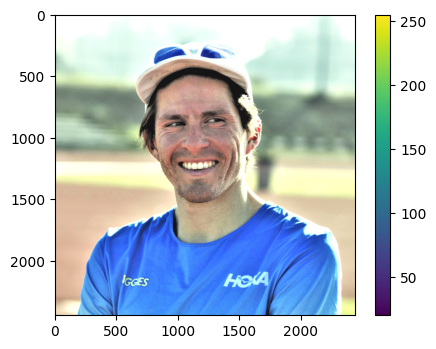

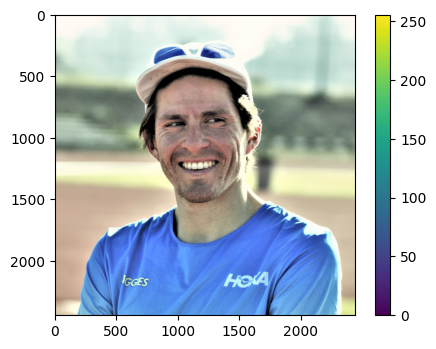

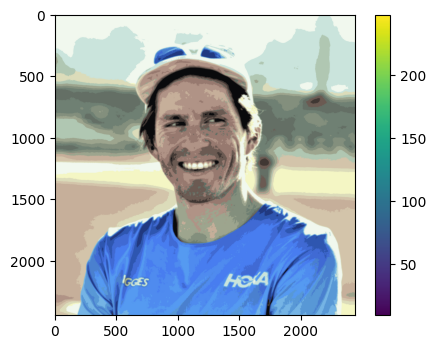

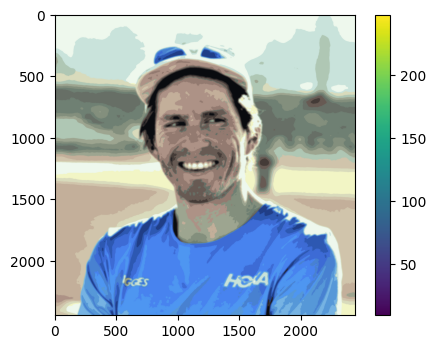

In [12]:
# see the progressive fading-ness of images from the raw enhanced, to the raw, to the first kmeans, to the second

im_utils.display_natural(im_enhanced)
im_utils.display_natural(im)
im_utils.display_natural(cv2.cvtColor(im_1, cv2.COLOR_LAB2BGR))
im_utils.display_natural(cv2.cvtColor(im_2, cv2.COLOR_LAB2BGR))

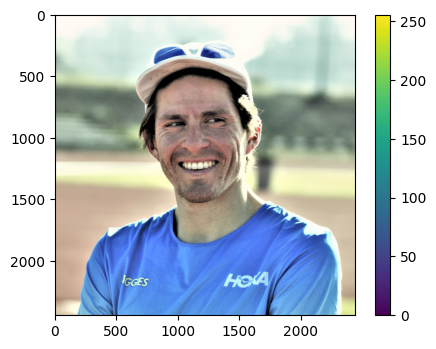

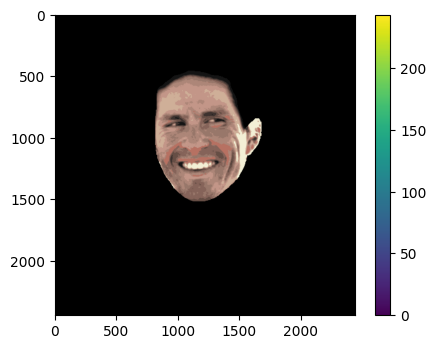

In [13]:
# Format the mask to uint8  
mask = M.binary_masks[0] * 255

# Define params
k = 10
blur = 12
a = 1.35
b = 15

# Apply K-means clustering
im_vibrant = im_utils.increase_vibrance(im, alpha=a, beta=b)
im_blur = im_utils.blur(im_vibrant, blur)
im_face_final = im_utils.kmeans_cluster_masked_image(im_blur, mask, k)

# let's see the clustered face from the enhanced image side by side with the original
im_utils.display_natural(im)
im_utils.display_natural(im_face_final)

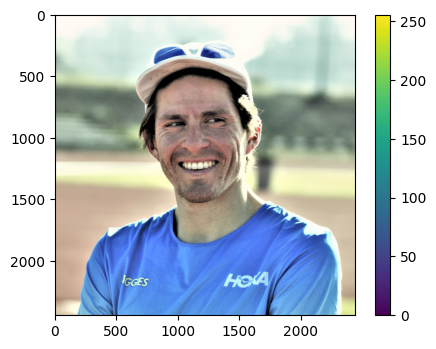

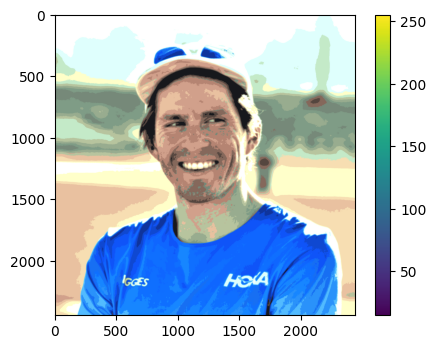

In [14]:
# Apply K-means clustering
#im_blur_temp = im_utils.blur(im, blur)
#im_face_final_temp = kmeans_cluster_masked_image(im_2, mask, k)

#im_utils.display_natural(cv2.cvtColor(im_2, cv2.COLOR_LAB2BGR))
im_utils.display_natural(im)

im_test = im_utils.brighten_image(
        im_utils.enhance_color_differences(
            cv2.cvtColor(im_1, cv2.COLOR_LAB2BGR)
        ),
        alpha = 1.1,
        beta = 15
    )

im_utils.display_natural(im_test)

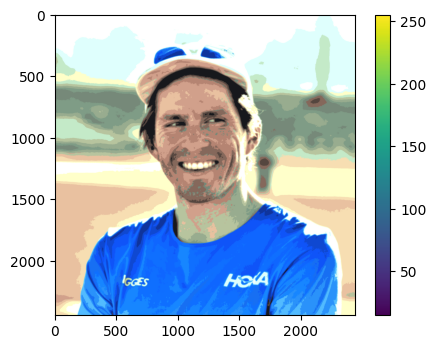

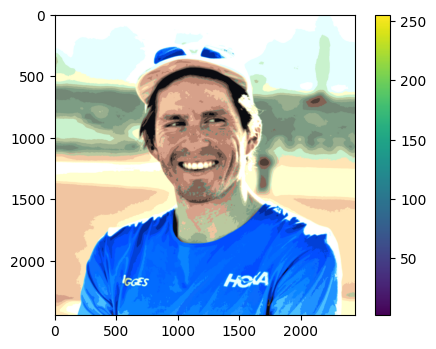

In [15]:
# Darken image / increase contrast
im_bp = im_utils.raise_black_point(im_test)
im_utils.display_natural(im_test)
im_utils.display_natural(im_bp)

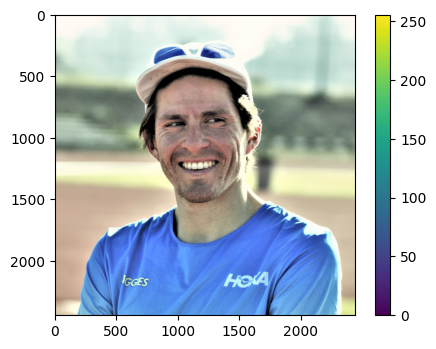

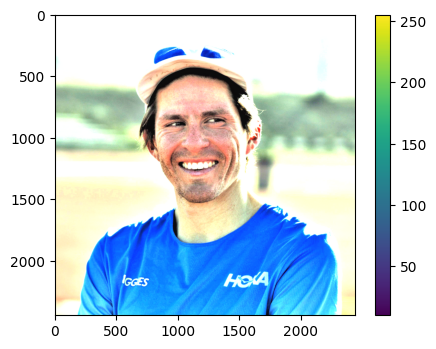

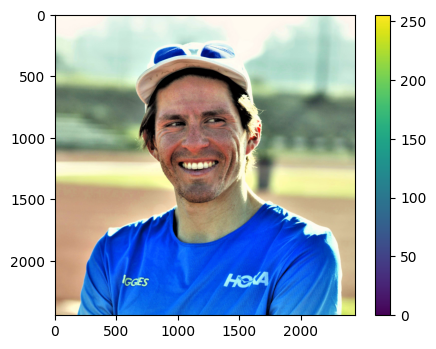

In [16]:
# Enhance skin tones
enhanced_image = im_utils.enhance_color_differences(im)
brightened_image = im_utils.brighten_image(enhanced_image)

# Display the results
im_utils.display_natural(im)
im_utils.display_natural(brightened_image)
im_utils.display_natural(enhanced_image)

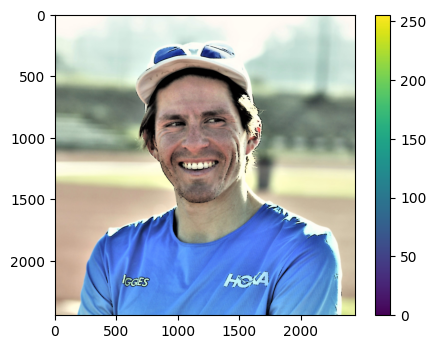

In [30]:
def cartoonify(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply bilateral filter to smooth the image while preserving edges
    gray = cv2.bilateralFilter(gray, 9, 75, 75)

    # Apply edge detection
    edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 9)

    # Combine color image with edges
    color = cv2.bilateralFilter(image, 9, 250, 250)
    cartoon = cv2.bitwise_and(color, color, mask=edges)

    return cartoon

im_utils.display_natural(cartoonify(im))


Original colors:


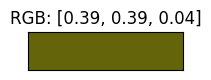

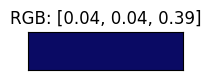

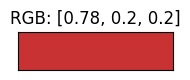


Modified colors:


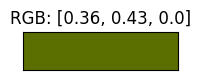

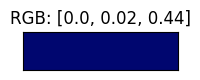

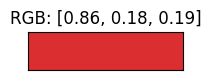

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def show_color(rgb_tuple):
    """Displays a color given an RGB tuple."""

    fig, ax = plt.subplots(figsize=(2, 0.5))

    # Create a rectangle patch
    rect = patches.Rectangle((0, 0), 1, 1, facecolor=rgb_tuple)

    # Add the patch to the axes
    ax.add_patch(rect)

    # Set the axis limits
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # Hide the axis ticks and labels
    plt.xticks([])
    plt.yticks([])

    plt.title(f"RGB: {[round(r, 2) for r in rgb_tuple]}")
    plt.show()


def enhance_color_differences(colors, factor):
    """
    Enhances the differences between a set of colors in the LAB color space.

    Args:
        colors (list): A list of RGB color tuples (e.g., [(255, 0, 0), (0, 255, 0), ...]).
        factor (float): Factor by which to enhance colors, a bit like a learning rate (e.g., 0.1)

    Returns:
        list: A list of modified RGB color tuples.
    """

    # Convert colors to LAB
    lab_colors = [cv2.cvtColor(np.array([[color]], dtype=np.uint8), cv2.COLOR_RGB2LAB)[0][0] for color in colors]

    # Calculate the mean LAB color
    mean_lab = np.mean(lab_colors, axis=0)

    # Adjust each color to be further from the mean
    modified_lab_colors = []
    for lab_color in lab_colors:
        delta = lab_color - mean_lab
        modified_lab_color = lab_color + delta * factor  # Increase the difference by this factor
        modified_lab_colors.append(modified_lab_color)

    # Convert back to RGB
    modified_rgb_colors = [
        cv2.cvtColor(np.array([[lab_color]], dtype=np.uint8), cv2.COLOR_LAB2RGB)[0][0]
        for lab_color in modified_lab_colors
    ]

    return modified_rgb_colors


# Example usage
if __name__ == "__main__":
    
    colors = [(100, 100, 10), (10, 10, 100), (200, 50, 50)]  # Example colors
    modified_colors = enhance_color_differences(colors, factor = 0.25)

    print("\nOriginal colors:")

    for color in colors:
        color_float = [
            float(c) / 255
            for c in color
        ]
        show_color(color_float)

    print("\nModified colors:")

    for color in modified_colors:
        color_float = [
            float(c) / 255
            for c in color
        ]
        show_color(color_float)


In [27]:
# get unique colors in face

start = time.time()
unique_colors, counts = im_utils.unique_colors(im_face_final, return_counts=True)
print(f"{round(time.time()-start, 1)}s elapsed")
unique_colors#, counts

6.2s elapsed


(array([[  0,   0,   0],
        [ 20,  20,  20],
        [ 47,  50,  61],
        [ 69,  78, 102],
        [ 89,  99, 133],
        [ 98, 113, 183],
        [106, 119, 152],
        [120, 134, 173],
        [136, 150, 195],
        [152, 175, 207],
        [213, 239, 243]], dtype=uint8),
 array([5308866,   25530,   19748,   38815,   88330,   38948,   96429,
         119031,  128463,   71999,   36977], dtype=int64))

In [21]:
sum_array = unique_colors.sum(axis=1)
sum_array

array([  0,  60, 158, 249, 321, 394, 377, 427, 481, 534, 695],
      dtype=uint32)

In [22]:
# get indices where sum of rgb's is less than 25

np.where(unique_colors.sum(axis=1) < 25)

(array([0], dtype=int64),)

In [23]:
r = np.delete(unique_colors, np.where(sum_array < 25), axis=0)

r

array([[ 20,  20,  20],
       [ 47,  50,  61],
       [ 69,  78, 102],
       [ 89,  99, 133],
       [ 98, 113, 183],
       [106, 119, 152],
       [120, 134, 173],
       [136, 150, 195],
       [152, 175, 207],
       [213, 239, 243]], dtype=uint8)

In [24]:
## Triple to remove
#triple_to_remove = np.array([0, 0, 0])
## Create a boolean mask to identify the triple
#mask = np.all(unique_colors == triple_to_remove, axis=1)
## Remove the triple using the mask
#result = unique_colors[~mask]

r_rgb = r[..., ::-1]
r_rgb

array([[ 20,  20,  20],
       [ 61,  50,  47],
       [102,  78,  69],
       [133,  99,  89],
       [183, 113,  98],
       [152, 119, 106],
       [173, 134, 120],
       [195, 150, 136],
       [207, 175, 152],
       [243, 239, 213]], dtype=uint8)

In [ ]:
r_adjust = enhance_color_differences(r_rgb, factor = 0.2)

print("\nOriginal colors:")

for color in r_rgb:
    color_float = [
        float(c) / 255
        for c in color
    ]
    show_color(color_float)

print("\nModified colors:")

for color in r_adjust:
    color_float = [
        float(c) / 255
        for c in color
    ]
    show_color(color_float)

new_result

In [ ]:
# replace colors in the segmented image with the new ones
# NOTE, this doesn't work yet, not quite sure why

clustered_rgb = clustered_image[..., ::-1]

for ix, orig_color in enumerate(r_rgb):
    new_color = r_adjust[ix]
    clustered_rgb[np.all(clustered_rgb == orig_color, axis=2)] = new_color

clustered_rgb[np.all(clustered_rgb == [0, 0, 0], axis=2)] = np.array([255, 255, 255])

#im_utils.display_natural(clustered_image)
#im_utils.display_image(clustered_rgb)

In [ ]:
np.unique(clustered_rgb.reshape(-1, clustered_rgb.shape[2]), axis=0)